# Regression Penalties in DLT

This notebook continues to discuss regression problems with DLT and covers various penalties:

1. `fixed-ridge`
2. `auto-ridge`
3. `lasso`

Generally speaking, regression coefficients are more robust under full Bayesian sampling and estimation.  The default setting `estimator='stan-mcmc'` will be used in this tutorial. Besides, a fixed and small smoothing parameters are used such as `level_sm_input=0.01` and `slope_sm_input=0.01` to facilitate  high dimensional regression.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import orbit
from orbit.utils.dataset import load_iclaims
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data
from orbit.constants.palette import OrbitPalette

In [2]:
print(orbit.__version__)

1.1.2alpha


## Regression on Simulated Dataset

A simulated dataset is used to demonstrate sparse regression.

In [13]:
import pandas as pd
from orbit.utils.simulation import make_trend, make_regression
from orbit.diagnostics.metrics import mse

A few utilities from the package is used to generate simulated data. For details, please refer to the API doc. In brief, the process generates observations $y$ such that

$$y_t = l_t + \sum_p^{P} \beta_p  x_{t, p}$$  
$$\text{ for } t = 1,2, \cdots , T$$

where

$$l_t = l_{t-1} + \delta_t$$
$$\delta_t \sim N(0, \sigma_{\delta})$$



### Regular Regression

To begin with, the setting $P=10$ and $T=100$ is used.

In [14]:
NUM_OF_REGRESSORS = 10
SERIES_LEN = 50
SEED = 20210101
# sample some coefficients
COEFS = np.random.default_rng(SEED).uniform(-1, 1, NUM_OF_REGRESSORS)
trend = make_trend(SERIES_LEN, rw_loc=0.01, rw_scale=0.1)
x, regression, coefs = make_regression(series_len=SERIES_LEN, coefs=COEFS)
print(regression.shape, x.shape)

(50,) (50, 10)


In [15]:
# combine trend and the regression
y = trend + regression

In [16]:
x_cols = [f"x{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "y"
dt_col = "date"
obs_matrix = np.concatenate([y.reshape(-1, 1), x], axis=1)
# make a data frame for orbit inputs
df = pd.DataFrame(obs_matrix, columns=[response_col] + x_cols)
# make some dummy date stamp
dt = pd.date_range(start='2016-01-04', periods=SERIES_LEN, freq="1W")
df['date'] = dt
df.shape

(50, 12)

Here is a peek on the coefficients.

In [17]:
coefs

array([ 0.38372743, -0.21084054,  0.5404565 , -0.21864409,  0.85529298,
       -0.83838077, -0.54550632,  0.80367924, -0.74643654, -0.26626975])

By default, `regression_penalty` is set as `fixed-ridge` i.e.

$$\beta_j ~\sim \mathcal{N}(\mu_j, \sigma_j^2)$$

with a default $\mu_j = 0$ and $\sigma_j = 1$ 

#### Fixed Ridge Penalty

In [18]:
%%time
dlt_fridge = DLT(
    response_col=response_col,
    date_col=dt_col,
    regressor_col=x_cols,
    seed=SEED,
    # this is default
    regression_penalty='fixed_ridge',
    # fixing the smoothing parameters to learn regression coefficients more effectively
    level_sm_input=0.01,
    slope_sm_input=0.01,
    num_warmup=4000,
)
dlt_fridge.fit(df=df)

CPU times: user 78.8 ms, sys: 64.8 ms, total: 144 ms
Wall time: 2.26 s


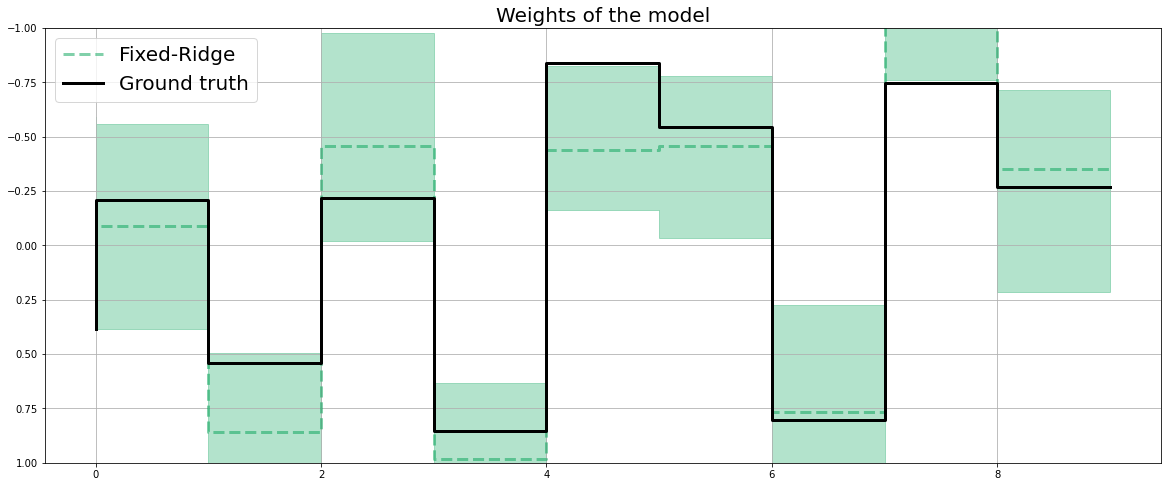

In [19]:
coef_fridge = np.quantile(dlt_fridge._posterior_samples['beta'], q=[0.05, 0.5, 0.95], axis=0 )
lw=3
idx = np.arange(NUM_OF_REGRESSORS)
plt.figure(figsize=(20, 8))
plt.title("Weights of the model", fontsize=20)
plt.plot(idx, coef_fridge[1], color=OrbitPalette.GREEN.value, linewidth=lw,  drawstyle='steps', label='Fixed-Ridge', alpha=0.5, linestyle='--')
plt.fill_between(idx, coef_fridge[0], coef_fridge[2], step='pre', alpha=0.3, color=OrbitPalette.GREEN.value)
plt.plot(coefs, color="black", linewidth=lw,  drawstyle='steps', label="Ground truth")
plt.ylim(1, -1)
plt.legend(prop={'size': 20})
plt.grid()

#### Auto-Ridge Penalty

Users can also set the `regression_penalty` to be `auto-ridge` in case users are not sure what to set for the `regressor_sigma_prior`.

Instead of using fixed scale in the coefficients prior, a prior can be assigned to them, i.e.

$$ \sigma_j \sim \text{Cauchy}^{+} {(0, \alpha)} $$

This can be done by setting `regression_penalty="auto_ridge"` with the argument `auto_ridge_scale` (default of `0.5`) set the prior $\alpha$. A higher `adapt_delta` is recommend to reduce divergence.  Check [here](https://mc-stan.org/rstanarm/reference/adapt_delta.html) for details of `adapt_delta`.

In [20]:
%%time
dlt_auto_ridge = DLT(
    response_col=response_col,
    date_col=dt_col,
    regressor_col=x_cols,
    seed=SEED,
    # this is default
    regression_penalty='auto_ridge',
    # fixing the smoothing parameters to learn regression coefficients more effectively
    level_sm_input=0.01,
    slope_sm_input=0.01,
    num_warmup=4000,
    # reduce divergence 
    stan_mcmc_control={'adapt_delta':0.9},
)
dlt_auto_ridge.fit(df=df)

CPU times: user 72.2 ms, sys: 66.1 ms, total: 138 ms
Wall time: 4.81 s


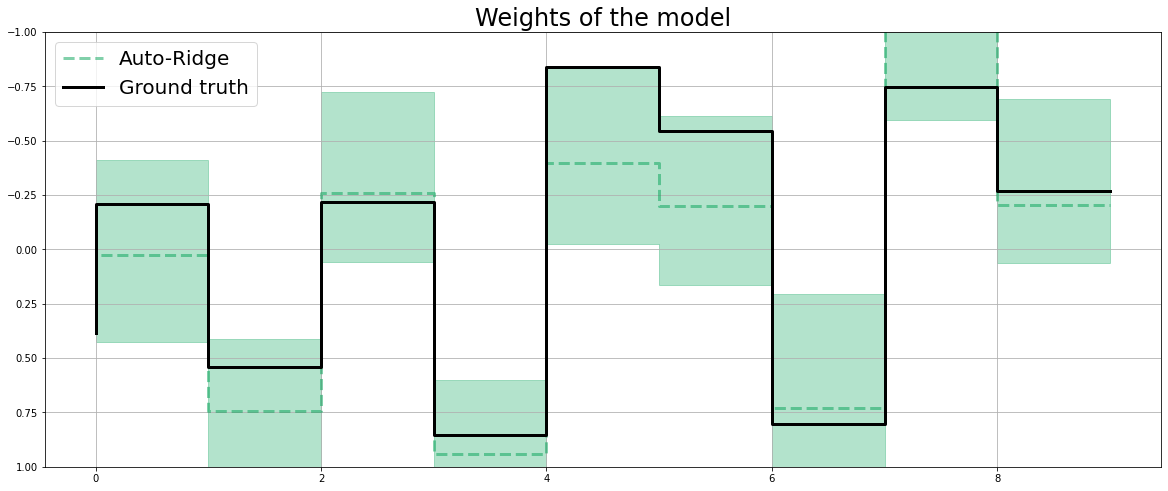

In [21]:
coef_auto_ridge = np.quantile(dlt_auto_ridge._posterior_samples['beta'], q=[0.05, 0.5, 0.95], axis=0 )
lw=3
idx = np.arange(NUM_OF_REGRESSORS)
plt.figure(figsize=(20, 8))
plt.title("Weights of the model", fontsize=24)
plt.plot(idx, coef_auto_ridge[1], color=OrbitPalette.GREEN.value, linewidth=lw,  drawstyle='steps', label='Auto-Ridge', alpha=0.5, linestyle='--')
plt.fill_between(idx, coef_auto_ridge[0], coef_auto_ridge[2], step='pre', alpha=0.3, color=OrbitPalette.GREEN.value)
plt.plot(coefs, color="black", linewidth=lw,  drawstyle='steps', label="Ground truth")
plt.ylim(1, -1)
plt.legend(prop={'size': 20})
plt.grid();

In [22]:
print('Fixed Ridge MSE:{:.3f}\nAuto Ridge MSE:{:.3f}'.format(
    mse(coef_fridge[1], coefs), mse(coef_auto_ridge[1], coefs)
))

Fixed Ridge MSE:0.082
Auto Ridge MSE:0.079


### Sparse Regrssion

In reality, users usually faces a more challenging problem with a much higher $P$ to $N$ ratio with a sparsity specified by the parameter `relevance=0.5` under the simulation process.

In [23]:
NUM_OF_REGRESSORS = 50
SERIES_LEN = 50
SEED = 20210101
COEFS = np.random.default_rng(SEED).uniform(0.3, 0.5, NUM_OF_REGRESSORS)
SIGNS = np.random.default_rng(SEED).choice([1, -1], NUM_OF_REGRESSORS)
# to mimic a either zero or relative observable coefficients
COEFS = COEFS * SIGNS
trend = make_trend(SERIES_LEN, rw_loc=0.01, rw_scale=0.1)
x, regression, coefs = make_regression(series_len=SERIES_LEN, coefs=COEFS, relevance=0.5)
print(regression.shape, x.shape)

(50,) (50, 50)


In [24]:
# generated sparsed coefficients
coefs

array([ 0.        ,  0.        , -0.45404565,  0.37813559,  0.        ,
        0.        ,  0.        ,  0.48036792, -0.32535635, -0.37337302,
       -0.42474576,  0.        , -0.37000755,  0.44887456,  0.47082836,
        0.        ,  0.32678039,  0.37436121,  0.38932392,  0.40216056,
        0.        ,  0.        , -0.3076828 , -0.35036047,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.45838674,  0.3171478 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.41599814,  0.        , -0.30964341,
       -0.42072894,  0.36255583,  0.        , -0.39326337,  0.44455655,
        0.        ,  0.        ,  0.30064161, -0.46083203,  0.        ])

In [25]:
# combine trend and the regression
y = trend + regression

In [26]:
x_cols = [f"x{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "y"
dt_col = "date"
obs_matrix = np.concatenate([y.reshape(-1, 1), x], axis=1)
# make a data frame for orbit inputs
df = pd.DataFrame(obs_matrix, columns=[response_col] + x_cols)
# make some dummy date stamp
dt = pd.date_range(start='2016-01-04', periods=SERIES_LEN, freq="1W")
df['date'] = dt
df.shape

(50, 52)

### Fixed Ridge Penalty

In [27]:
dlt_fridge = DLT(
    response_col=response_col,
    date_col=dt_col,
    regressor_col=x_cols,
    seed=SEED,
    level_sm_input=0.01,
    slope_sm_input=0.01,
    num_warmup=8000,
)
dlt_fridge.fit(df=df)

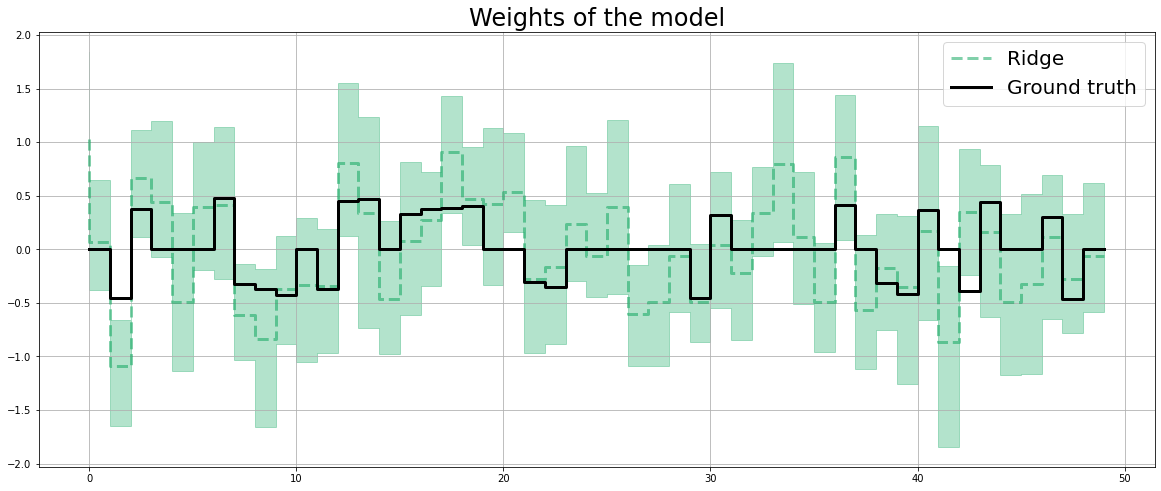

In [28]:
coef_fridge = np.quantile(dlt_fridge._posterior_samples['beta'], q=[0.05, 0.5, 0.95], axis=0 )
lw=3
idx = np.arange(NUM_OF_REGRESSORS)
plt.figure(figsize=(20, 8))
plt.title("Weights of the model", fontsize=24)
plt.plot(coef_fridge[1], color=OrbitPalette.GREEN.value, linewidth=lw,  drawstyle='steps', label="Ridge", alpha=0.5, linestyle='--')
plt.fill_between(idx, coef_fridge[0], coef_fridge[2], step='pre', alpha=0.3, color=OrbitPalette.GREEN.value)
plt.plot(coefs, color="black", linewidth=lw,  drawstyle='steps', label="Ground truth")
plt.legend(prop={'size': 20})
plt.grid();

#### LASSO  Penalty

In high $P$ to $N$ problems, *LASS0* penalty usually shines compared to *Ridge* penalty.

In [29]:
dlt_lasso = DLT(
    response_col=response_col,
    date_col=dt_col,
    regressor_col=x_cols,
    seed=SEED,
    regression_penalty='lasso',
    level_sm_input=0.01,
    slope_sm_input=0.01,
    num_warmup=8000,
)
dlt_lasso.fit(df=df)

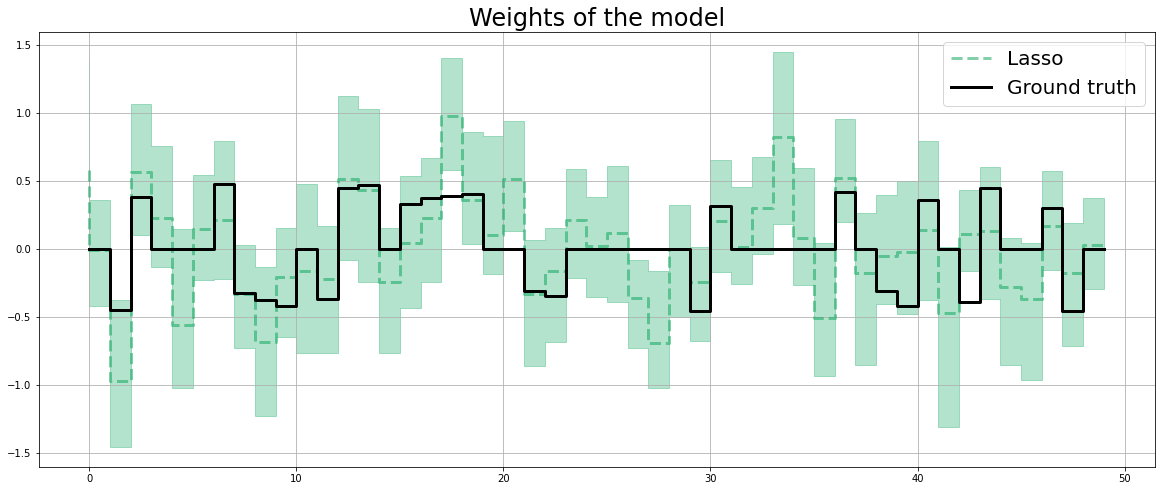

In [30]:
coef_lasso = np.quantile(dlt_lasso._posterior_samples['beta'], q=[0.05, 0.5, 0.95], axis=0 )
lw=3
idx = np.arange(NUM_OF_REGRESSORS)
plt.figure(figsize=(20, 8))
plt.title("Weights of the model", fontsize=24)
plt.plot(coef_lasso[1], color=OrbitPalette.GREEN.value, linewidth=lw,  drawstyle='steps', label="Lasso", alpha=0.5, linestyle='--')
plt.fill_between(idx, coef_lasso[0], coef_lasso[2], step='pre', alpha=0.3, color=OrbitPalette.GREEN.value)
plt.plot(coefs, color="black", linewidth=lw,  drawstyle='steps', label="Ground truth")
plt.legend(prop={'size': 20})
plt.grid();

In [31]:
print('Fixed Ridge MSE:{:.3f}\nLASSO MSE:{:.3f}'.format(
    mse(coef_fridge[1], coefs), mse(coef_lasso[1], coefs)
))

Fixed Ridge MSE:0.162
LASSO MSE:0.102


## Summary

This notebook covers a few choices of penalty in regression regularization. A `lasso` and `auto-ridge` can be considered in highly sparse data.